# MIRNETv2

## 배경
* 야간 주행에서 운전자의 시각환경을 개선시키기 위해서 딥러닝 도입
* 실시간성과 성능을 모두 만족시켜야 함

## Dataset
* 기존 LOL 데이터를 학습하면 조명이 많은 도로에서는 성능이 안좋음
* 데이콘 빛번짐 데이터 참고
* 빛번짐과 low light enhancement를 동시에 해결하기 위해서 빛번짐 데이터 수정
* train_input 이미지를 darkness 를 가함.



# 데이터셋 다운로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq '/content/drive/MyDrive/train_input_img.zip' -d '/content/sample_data/train_input_img'

In [3]:
!unzip -qq '/content/drive/MyDrive/train_label_img.zip' -d '/content/sample_data/train_label_img'

# 데이터셋 전처리
* 입력 이미지를 어둡게 만들고 train_time을 개선하기 위해서 이미지 크기도 조절
* 이미지 크기는 512*512 로 축소

In [25]:
import cv2
import numpy as np
import os
# 입력 이미지 디렉토리와 출력 이미지 디렉토리 설정
input_directory = "/content/sample_data/train_input_img"
output_directory = "/content/sample_data/train_input_img"

# 크기를 변경할 이미지의 너비와 높이 설정
new_width = 512
new_height = 512

# 입력 디렉토리 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir(input_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        input_path = os.path.join(input_directory, filename)
        output_path = os.path.join(output_directory, filename)

        # 이미지 읽기
        img = cv2.imread(input_path)
        val = 100
        # 이미지 크기 조정
        img_resized = cv2.resize(img, (new_width, new_height))
        # 이미지 어둡게 만들기
        dark_factor = 0.5  # 조절하고자 하는 어둡게 만들기 정도 (0보다 작은 값은 0으로 고정됨)
        darkened_image = np.clip(img_resized * dark_factor, 0, 255).astype(np.uint8)
        os.remove(input_path)
        # 크기가 조정된 이미지를 저장
        cv2.imwrite(output_path, darkened_image)

In [5]:
# 입력 이미지 디렉토리와 출력 이미지 디렉토리 설정
input_directory = "/content/sample_data/train_label_img"
output_directory = "/content/sample_data/train_label_img"

# 크기를 변경할 이미지의 너비와 높이 설정
new_width = 512
new_height = 512

# 입력 디렉토리 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir(input_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        input_path = os.path.join(input_directory, filename)
        output_path = os.path.join(output_directory, filename)

        # 이미지 읽기
        img = cv2.imread(input_path)

        # 이미지 크기 조정
        img_resized = cv2.resize(img, (new_width, new_height))
        os.remove(input_path)
        # 크기가 조정된 이미지를 저장
        cv2.imwrite(output_path, img_resized)

# 데이터셋 객체화
* 이미지 파일들을 케라스가 제공하는 데이터셋 객체로 변환
* validation dataset 생성

In [16]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 500


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("/content/sample_data/train_input_img/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("/content/sample_data/train_label_img/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("/content/sample_data/train_input_img/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("/content/sample_data/train_label_img/*"))[MAX_TRAIN_IMAGES:]


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>


# MIRnetv2 모델 구조
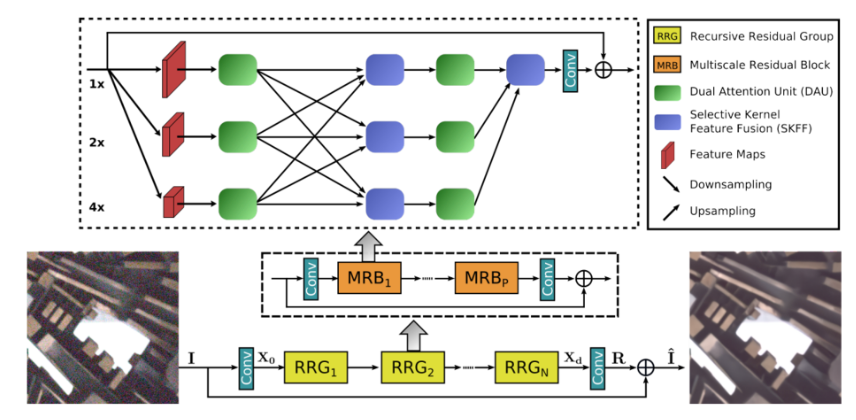

#Selective Kernel Feature Fusion
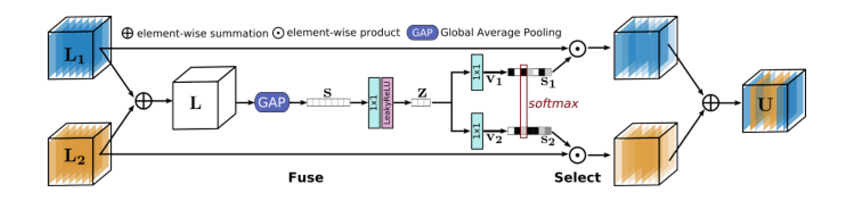


In [7]:
class SKFF(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.channels = batch_input_shape[-1]
    self.combined_feature = layers.Add()
    self.gap = layers.GlobalAveragePooling2D()
    self.compact_feature_representation = layers.Conv2D(
        filters=self.channels // 8, kernel_size=(1, 1), activation="relu"
    )
    self.feature_descriptor_1 = layers.Conv2D(
        self.channels, kernel_size=(1, 1), activation="softmax"
    )
    self.feature_descriptor_2 = layers.Conv2D(
        self.channels, kernel_size=(1, 1), activation="softmax"
    )
    self.feature_descriptor_3 = layers.Conv2D(
        self.channels, kernel_size=(1, 1), activation="softmax"
    )
    self.aggregated_feature = layers.Add()
    super().build(batch_input_shape)

  def call(self, *X):
     multi_scale_feature_1, multi_scale_feature_2 = X
     layer1 = self.combined_feature([multi_scale_feature_1, multi_scale_feature_2])
     layer2 = self.gap(layer1)
     channel_wise_statistics = tf.reshape(layer2, shape=(-1, 1, 1, self.channels))
     layer3 = self.compact_feature_representation(channel_wise_statistics)

     descriptor1 = self.feature_descriptor_1(layer3)
     descriptor2 = self.feature_descriptor_2(layer3)

     feature_1 = multi_scale_feature_1 * descriptor1
     feature_2 = multi_scale_feature_2 * descriptor2

     out = self.aggregated_feature([feature_1, feature_2])
     return out

# compute_output_shape 동적인 층?
# get_config 정의 필요 ? -> init안에 정의 없음

# Residual Contextual Block
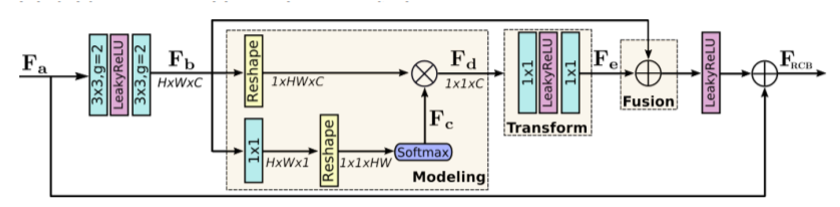

In [8]:
from keras.layers import LeakyReLU

class  residual_contextual_block(keras.layers.Layer):
   def __init__(self, **kwargs):
    super().__init__(**kwargs)

   def build(self, batch_input_shape):
    self.batch = batch_input_shape[0]
    if len(batch_input_shape)<=3:
      self.batch = 1
    self.channels = batch_input_shape[-1]
    self.conv1 =  layers.Conv2D(
        self.channels, kernel_size=(3, 3), padding="same",groups=2
    )
    self.leakyRelu = LeakyReLU(alpha=0.3)
    self.conv2 =  layers.Conv2D(
        self.channels, kernel_size=(3, 3), padding="same", groups=2
    )
    self.conv3 =  layers.Conv2D(
       1, kernel_size=(1, 1), padding="same"
    )
    self.softmax = tf.keras.layers.Softmax()
    self.conv4 = layers.Conv2D(
        filters= self.channels, kernel_size=(1, 1))
    self.conv5 = layers.Conv2D(
        filters= self.channels, kernel_size=(1, 1))
   def call(self, x):
    out = self.conv1(x)
    out = self.leakyRelu(out)
    fb = self.conv2(out)
    fc = self.conv3(fb)
    fc = tf.reshape(fc, shape=(self.batch,1, 1, -1))
    fc = self.softmax(fc)
    fd = tf.reshape(fb, shape=(self.batch, 1,-1, self.channels))
    fd =  tf.linalg.matmul(fc, fd)
    fe = self.conv4(fd)
    fe = self.leakyRelu(fe)
    fe = self.conv4(fe)
    frcb = fe + fb
    frcb = self.leakyRelu(frcb)
    rst = x + frcb
    return rst


# Sampling Module
* convolution stream 을 만들기 위해서 사용되는 모듈
* 이미지 크기는 줄이고 채널을 늘리거나 혹은 그 반대이다.

In [9]:
# Recursive Residual Modules
class down_sampling_module(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.channels = batch_input_shape[-1]
    self.conv1 = layers.Conv2D(self.channels, kernel_size=(1, 1), activation="relu")
    self.conv2 = layers.Conv2D(
        self.channels, kernel_size=(3, 3), padding="same", activation="relu"
    )
    self.MP1 =  layers.MaxPooling2D()
    self.MP2 =  layers.MaxPooling2D()

    self.conv3 = layers.Conv2D(self.channels * 2, kernel_size=(1, 1))
    self.conv4 = layers.Conv2D(self.channels * 2, kernel_size=(1, 1))
    self.add1 = layers.Add()
    super().build(batch_input_shape)

  def call(self, x):
    #print("-----down sampling ----")
    #print(x)
    main_branch = self.conv1(x)
    #print(main_branch)
    main_branch = self.conv2(main_branch)
    #print(main_branch)
    main_branch = self.MP1(main_branch)
    #print(main_branch)
    main_branch = self.conv3(main_branch)
    #print(main_branch)
    skip_branch = self.MP2(x)
    #print(skip_branch)
    skip_branch = self.conv4(skip_branch)
    #print(skip_branch)
    add = self.add1([main_branch, skip_branch])
    #print(add)

    return add

class up_sampling_module(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.channels = batch_input_shape[-1]
    self.conv1 = layers.Conv2D(self.channels, kernel_size=(1, 1), activation="relu")
    self.conv2 = layers.Conv2D(
        self.channels, kernel_size=(3, 3), padding="same", activation="relu"
    )
    self.UP1 =  layers.UpSampling2D()
    self.UP2 =  layers.UpSampling2D()

    self.conv3 = layers.Conv2D(self.channels // 2, kernel_size=(1, 1))
    self.conv4 = layers.Conv2D(self.channels // 2, kernel_size=(1, 1))
    self.add1 = layers.Add()
    super().build(batch_input_shape)

  def call(self, x):
    main_branch = self.conv1(x)
    main_branch = self.conv2(main_branch)
    main_branch = self.UP1(main_branch)
    main_branch = self.conv3(main_branch)
    skip_branch = self.UP2(x)
    skip_branch = self.conv4(skip_branch)
    return self.add1([main_branch, skip_branch])

# 모델 구성

In [10]:
class multi_scale_residual_block(keras.layers.Layer):
  def __init__(self, channels ,**kwargs):
    super().__init__(**kwargs)
    self.channels = channels
  def build(self, batch_input_shape):
    self.dsm1 = down_sampling_module()
    self.dsm2 = down_sampling_module()
    self.usm1 = up_sampling_module()
    self.usm2 = up_sampling_module()
    self.usm3 = up_sampling_module()
    self.usm4 = up_sampling_module()
    self.rcb1 = residual_contextual_block()
    self.rcb2 = residual_contextual_block()
    self.rcb3 = residual_contextual_block()
    self.rcb4 = residual_contextual_block()
    self.rcb5 = residual_contextual_block()
    self.rcb6 = residual_contextual_block()
    self.skff1 = SKFF()
    self.skff2 = SKFF()
    self.skff3 = SKFF()
    self.skff4 = SKFF()
    self.conv1 = layers.Conv2D(self.channels, kernel_size=(3, 3), padding="same")
    self.add1 = layers.Add()
    super().build(batch_input_shape)

  def call(self, x):
    # features
    level1 = x
    level2 = self.dsm1(x)
    level3 = self.dsm2(level2)
    # RCB
    level1_rcb = self.rcb1(level1)
    level2_rcb = self.rcb2(level2)
    level3_rcb = self.rcb3(level3)
    # SKFF
    level2_skff = self.skff1(
        level2_rcb,
        self.usm1(level3_rcb)
      )
    level1_skff = self.skff2(
        level1_rcb,
        self.usm2(level2_skff)
    )
    level3_skff = self.skff3(
       self.rcb4(level2_skff),
       self.usm3(self.rcb5(level3_rcb))
    )
    level4_skff = self.skff4(
        self.rcb6(level1_skff),
        self.usm4(level3_skff)
    )

    # end
    conv = self.conv1(level4_skff)
    return self.add1([x, conv])


In [11]:
class recursive_residual_group(keras.layers.Layer):
  def __init__(self,num_mrb, channels, **kwargs):
    self.num_mrb = num_mrb
    self.channels = channels
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.conv1 = layers.Conv2D(self.channels, kernel_size=(3, 3), padding="same")
    self.conv2 = layers.Conv2D(self.channels, kernel_size=(3, 3), padding="same")
    self.msrbs = [ multi_scale_residual_block(self.channels) for _ in range(self.num_mrb) ]
    self.add1 = layers.Add()

  def call(self, x):
    conv = self.conv1(x)
    for msrb in self.msrbs:
      conv = msrb(conv)
    conv = self.conv2(conv)
    return self.add1([conv, x])

class mirnet_model(keras.Model):
  def __init__(self,num_mrb, channels, num_rrg, **kwargs):
    self.num_mrb = num_mrb
    self.channels = channels
    self.num_rrg = num_rrg
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.conv1 = layers.Conv2D(self.channels, kernel_size=(3, 3), padding="same")
    self.rrgs = [recursive_residual_group(self.num_mrb, self.channels) for _ in range(self.num_rrg)]
    self.conv2 = layers.Conv2D(3, kernel_size=(3, 3), padding="same")
    self.add1 = layers.Add()

  def call(self, x):
    conv = self.conv1(x)
    for rrg in self.rrgs:
      conv = rrg(conv)
    conv = self.conv2(conv)
    return self.add1([x, conv])

model = mirnet_model(num_rrg=1, num_mrb=1, channels=64)

# 모델 학습

Epoch 1/50
75/75 [==============================] - 36s 153ms/step - loss: 0.0571 - peak_signal_noise_ratio: 71.8913 - val_loss: 0.0519 - val_peak_signal_noise_ratio: 75.9137 - lr: 1.0000e-04
Epoch 2/50
75/75 [==============================] - 11s 140ms/step - loss: 0.0442 - peak_signal_noise_ratio: 73.5142 - val_loss: 0.0496 - val_peak_signal_noise_ratio: 77.0903 - lr: 1.0000e-04
Epoch 3/50
75/75 [==============================] - 11s 146ms/step - loss: 0.0437 - peak_signal_noise_ratio: 73.5649 - val_loss: 0.0468 - val_peak_signal_noise_ratio: 77.0492 - lr: 1.0000e-04
Epoch 4/50
75/75 [==============================] - 10s 139ms/step - loss: 0.0463 - peak_signal_noise_ratio: 73.3901 - val_loss: 0.0455 - val_peak_signal_noise_ratio: 76.5817 - lr: 1.0000e-04
Epoch 5/50
75/75 [==============================] - 11s 149ms/step - loss: 0.0463 - peak_signal_noise_ratio: 73.1408 - val_loss: 0.0418 - val_peak_signal_noise_ratio: 77.1175 - lr: 1.0000e-04
Epoch 6/50
75/75 [======================

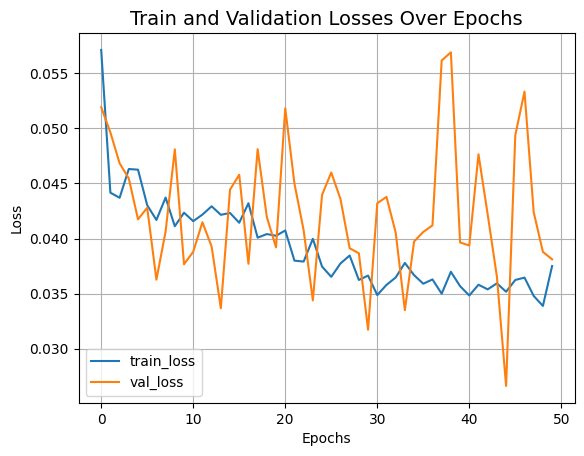

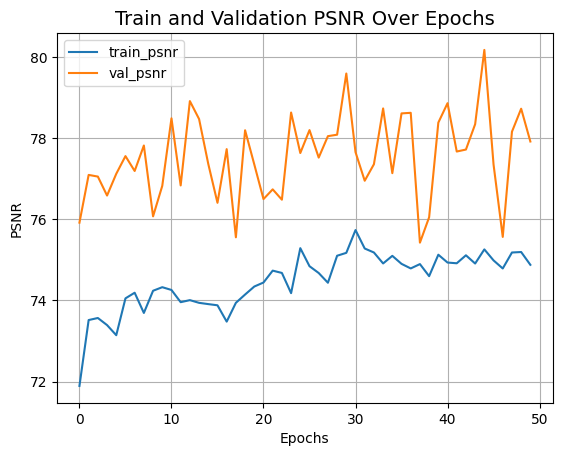

In [27]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()